In [43]:
import tenseal.sealapi as seal
from polynomial import enc_poly, divByPo2
import util
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [44]:
parms = seal.EncryptionParameters(seal.SCHEME_TYPE.CKKS)
# How large should plaintexts be? This determines number of available levels for a certain bit size, number of data slots and security. 
poly_modulus_degree = 2**15
# Bit size for primes in modulus chain. Larger -> more available options, slower performance. 
bit_size = 50
# How many data levels do we need?
levels = 10
# Create modulus chain
mod_chain_bit_size = [bit_size for k in range(levels)]
# First and last primes are "special" in SEAL, and should always be 60 bit primes.  
mod_chain_bit_size.insert(0,60)
mod_chain_bit_size.append(60)

# Set parameters (this involves involves finding candidate primes for the modulus chain)
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(seal.CoeffModulus.Create(poly_modulus_degree, mod_chain_bit_size))
scale = pow(2.0, bit_size)

# What are the specific primes in the modulus chain? These help calculate exact scales 
# of rescaled ciphertexts later on in this notebook. 
primes = [modulus.value() for modulus in parms.coeff_modulus()]

# The creation of a SEAL context does not include a check to see if parameter settings
# are valid. This is done later during key creation. 
context = seal.SEALContext(parms,True,seal.SEC_LEVEL_TYPE.TC128)

util.print_parameters(context)

print("|\t Max Bit Count: " + str(seal.CoeffModulus.MaxBitCount(poly_modulus_degree, seal.SEC_LEVEL_TYPE.TC128)))

/
|Encryption parameters: 
|	scheme: CKKS
|	poly_modulus_degree: 32768
|	coeff_modulus_size: 620 (60 50 50 50 50 50 50 50 50 50 50 60) bits
|	 Max Bit Count: 881


All keys geneated using `seal::KeyGenerator`. We also need an `encoder`, `evaluator`, `encryptor`, and `decryptor`. 

In [45]:

keygen = seal.KeyGenerator(context)
secret_key = keygen.secret_key()

public_key = seal.PublicKey()
keygen.create_public_key(public_key)

relin_keys = seal.RelinKeys()
keygen.create_relin_keys(relin_keys)

galois_keys = seal.GaloisKeys()
keygen.create_galois_keys()

encryptor = seal.Encryptor(context, public_key)
evaluator = seal.Evaluator(context)
decryptor = seal.Decryptor(context, secret_key)

encoder = seal.CKKSEncoder(context)
slot_count = seal.CKKSEncoder.slot_count(encoder)

print('Number of slots: ' + str(slot_count))

Number of slots: 16384


Let $x$ be the encrypted difference between two number in $a,b\in[0,1]$, such that $x\in[-1,1]$. We use batch encoding, meaning the comparison between several numbers can be done in a Single Instruction Multiple Data (SIMD) fashion. 

In [46]:
a=0.5;b=np.linspace(0, 1,1000)
x = a-b

x_plain = seal.Plaintext()
encoder.encode(x,scale, x_plain)

x_enc = seal.Ciphertext()
encryptor.encrypt(x_plain, x_enc)

The polynomial we want to calculate is
* $g(x) = (35x-35x^3+21x^5-5x^7)/2^4$

which is done using the function `enc_poly` from the `polynomial` module.

Note that the resulting ciphertext has a different scale, $\tilde{\Delta}$, compared to the bit-sizes of the modulus chain. This means we can not achieve scale stabilization. 
To compensate for this, manually change the scale of the resulting CT 
such that it matches the original scale, $\Delta$. 

- `enc_g_x` is an encryption of $\tilde{\Delta}g(x)$ with scale $\tilde{\Delta}$
- Multiplying with plaintext $\Delta/\tilde{\Delta}$ which has scale $\tilde{\Delta}$ will yield an encryption of $\Delta g(x)$ with scale $\tilde{\Delta}^2$

Multiplying by the plain factor $\Delta/\tilde{\Delta}$ and manually changing the scale gives an encryption of $\Delta g(x)$ with the correct scale factor, but consumes an additional CT-level. 

Providing the original scale, together with choosing `reset_scale`=True will perform this manual rescaling after computation is done. This consumes one CT-level but produces a CT with the same scale as a fresh CT, making scale stabilization and further operations possible. 

In [47]:
coeffs = [35, -35, 21, -5]
degrees = [1, 3, 5, 7]

power = 4

enc_g_x = enc_poly(x_enc, coeffs,degrees, power, evaluator, context, encoder, relin_keys, encryptor,True,scale)

In [48]:
plain_g_x = (35*x-35*x**3+21*x**5-5*x**7)/2**4

util.print_info(enc_g_x, decryptor, context, encoder, plain_g_x)

	Enc. result:	0.858886724456676
	Plain result:	0.85888671875
	Scale:	1125899906842624.0
	Ch. ind:	5


Now we are ready to calculate $f(g(x))$ where 
* $f(x) = (4589x-16577x^3+25614x^5-12860x^7)/2^{10}$

In [49]:
# Note that this time we do not want to waste a CT level to manually reset the scale. 
coeffs = [4589, -16577, 25614, -12860]
power = 10

plain_compare = (4589*plain_g_x-16577*plain_g_x**3+25614*plain_g_x**5-12860*plain_g_x**7)/2**10
enc_compare = enc_poly(enc_g_x, coeffs, degrees, power, evaluator, context, encoder, relin_keys, encryptor, False)

Comparison function is actually approximated by a scaled and transformed version of the composite polynomial. The approximation is given by 
* $x>y \approx (f \circ g (x-y)+1)/2$

In [50]:
plain_one = seal.Plaintext()
encoder.encode(1, enc_compare.scale, plain_one)
evaluator.mod_switch_to_inplace(plain_one, enc_compare.parms_id())

evaluator.add_plain_inplace(enc_compare, plain_one)
divByPo2(enc_compare, 1)



In [51]:
plain_compare = (plain_compare+1)/2
util.print_info(enc_compare, decryptor, context, encoder, plain_compare)

	Enc. result:	0.9766549467331299
	Plain result:	0.9766549519720602
	Scale:	2.305843230001838e+18
	Ch. ind:	1


In [52]:
result = seal.Plaintext()
decryptor.decrypt(enc_compare, result)
result = np.array(encoder.decode_double(result)[0:1000])

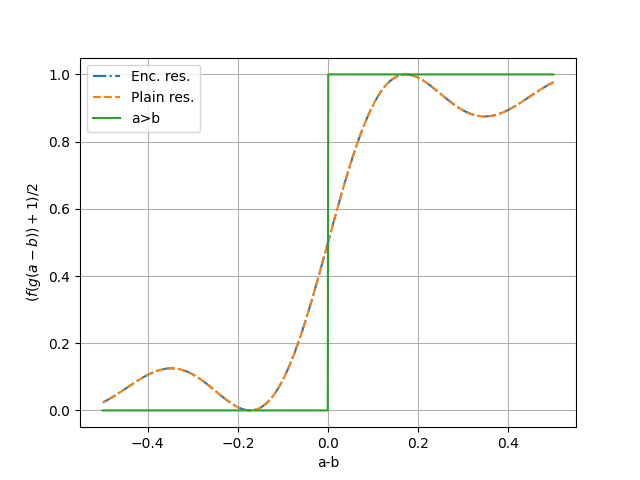

In [54]:

fig, ax = plt.subplots()
ax.plot(x, result, '-.')
ax.plot(x, plain_compare, '--')
ax.plot(x, x>0)
ax.set_ylabel("$(f(g(a-b))+1)/2$")
ax.set_xlabel("a-b")
ax.grid(True)
ax.legend(['Enc. res.', 'Plain res.', 'a>b'])
plt.show()